In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

# Visualising the Classes and time

from sklearn.decomposition import PCA, IncrementalPCA, LatentDirichletAllocation
from tqdm.notebook import tqdm, trange

In [ ]:
# Loading the normalised csv data into a DataFrame
# StandardScaler used
df_normt = pd.read_csv('transactions_norm_standardscaler.csv')

In [ ]:
df_normt.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Laundering_type,Is_laundering
0,-0.716449,-1.0,1.000000,-0.775333,-0.285139,0.171435,0.23455,0.156459,0.226096,-1.000000,-1.000000,0
1,-0.716400,-1.0,-1.000000,1.000000,-0.107099,0.171435,-1.00000,0.156459,-0.191672,0.793335,-0.678404,0
2,-0.716400,-1.0,-1.000000,-0.208419,0.217274,0.171435,0.23455,0.156459,0.226096,-0.156956,1.000000,0
3,-0.716352,-1.0,0.128225,1.000000,0.122274,0.171435,0.23455,0.156459,0.226096,-1.000000,-0.989758,0
4,-0.716352,-1.0,1.000000,-0.416904,-0.337604,0.171435,0.23455,0.156459,0.226096,-1.000000,-1.000000,0


In [ ]:
df_normt.keys()

Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Laundering_type',
       'Is_laundering'],
      dtype='object')

In [ ]:
df_normt.shape

(9504852, 12)

In [ ]:
X = df_normt.iloc[:,:-1].values
X

array([[-0.71644869, -1.        ,  1.        , ...,  0.22609619,
        -1.        , -1.        ],
       [-0.71640014, -1.        , -1.        , ..., -0.19167208,
         0.79333475, -0.67840436],
       [-0.71640014, -1.        , -1.        , ...,  0.22609619,
        -0.15695646,  1.        ],
       ...,
       [-0.65299912,  1.        ,  0.78858573, ...,  0.22609619,
        -1.        ,  1.        ],
       [-0.65275639,  1.        , -1.        , ...,  0.22609619,
        -1.        , -0.98975786],
       [-0.65270784,  1.        , -1.        , ...,  0.22609619,
        -1.        , -0.67840436]])

In [ ]:
# Feature Extraction using Principal Componemt Analysis

pca = PCA(n_components=2)
x_pca = pca.fit_transform(X)

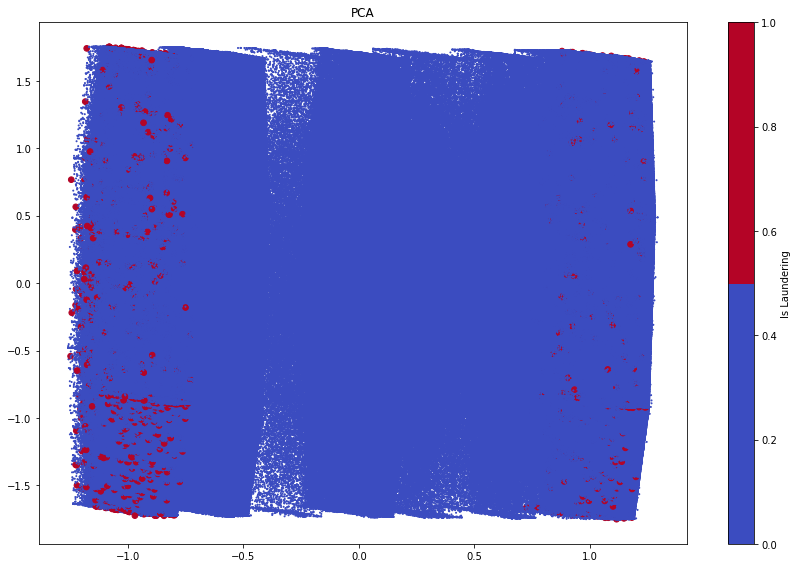

In [ ]:
# Visualising

fig, axes = plt.subplots(nrows=1, figsize=(12, 8))

sizes = pd.Series(df_normt['Is_laundering']+1).pow(5)

cmap = plt.get_cmap('coolwarm', 2)

scatter1 = axes.scatter(x_pca[:, 0], x_pca[:, 1], s=sizes, c=df_normt['Is_laundering'].values, cmap = cmap)


cbar = plt.colorbar(scatter1, ax=axes)
cbar.set_label('Is Laundering')

axes.set_title('PCA')
fig.tight_layout()
plt.show()

In [ ]:
df_normt["Is_laundering"].value_counts()

0    9494979
1       9873
Name: Is_laundering, dtype: int64

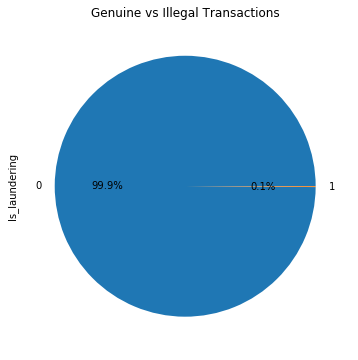

In [ ]:
plt.figure(figsize=(6, 6))

df_normt["Is_laundering"].value_counts().plot(kind='pie', autopct='%1.1f%%', title = 'Genuine vs Illegal Transactions')

plt.show()

# Addressing Class Imbalance

In [ ]:
# Creating separate DataFrames for Laundering Transactions and Normal Transactions
t_anom = df_normt[df_normt["Is_laundering"]==1]
t_norm = df_normt[df_normt["Is_laundering"]==0]

In [ ]:
t_anom.shape

(9873, 12)

In [ ]:
t_norm.shape

(9494979, 12)

In [ ]:
# Using Conditional  List Comphersion to select the feature columns

feature_cols = [item for item in df_normt.columns if item != 'Is_laundering']
feature_cols

['Time',
 'Date',
 'Sender_account',
 'Receiver_account',
 'Amount',
 'Payment_currency',
 'Received_currency',
 'Sender_bank_location',
 'Receiver_bank_location',
 'Payment_type',
 'Laundering_type']

In [ ]:
# Applying SMOTE to balance the dataset

from imblearn.over_sampling import SMOTE

X= df_normt[feature_cols]
y= df_normt['Is_laundering']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
y_resampled.value_counts()

1    9494979
0    9494979
Name: Is_laundering, dtype: int64

# Training

In [ ]:
# Spliting data into training and testing samples

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=0)

In [ ]:
X_test.shape

(4747490, 11)

In [ ]:
y_test.shape

(4747490,)

In [ ]:
y_test.value_counts()

1    2373993
0    2373497
Name: Is_laundering, dtype: int64

# Supervised Models

In [ ]:
# Naive Bayes Classification

# import naive bayes classifier
from sklearn.naive_bayes import GaussianNB

# initialize the Naive Bayes classifier
NB = GaussianNB()

#fit the classifier to the data
nb_model = NB.fit(X_train, y_train)

#use the resulting model to predict value on the test sey
nb_predictions = NB.predict(X_test)


#performance metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

print(confusion_matrix(y_test, nb_predictions), '\n')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, nb_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, nb_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, nb_predictions)), '\n')

print(classification_report(y_test, nb_predictions))
print("Accuracy:", accuracy_score(y_test, nb_predictions))
print("AUC:", roc_auc_score(y_test, nb_predictions))

[[2112975  260522]
 [1540034  833959]] 

Mean Absolute Error: 0.37926483257468685
Mean Squared Error: 0.37926483257468685
Root Mean Squared Error: 0.6158448120871741 

              precision    recall  f1-score   support

           0       0.58      0.89      0.70   2373497
           1       0.76      0.35      0.48   2373993

    accuracy                           0.62   4747490
   macro avg       0.67      0.62      0.59   4747490
weighted avg       0.67      0.62      0.59   4747490

Accuracy: 0.6207351674253132
AUC: 0.6207633210341394


In [ ]:
# AdaBoost Classification

from sklearn.ensemble import AdaBoostClassifier

# Initialize the AdaBoost classifier
adb = AdaBoostClassifier(n_estimators=50, random_state=0)

# Fit the model to the training data
adb_model = adb.fit(X_train, y_train)

# Make predictions on the test data
adb_predictions = adb.predict(X_test)

#performance metrics

print(confusion_matrix(y_test, adb_predictions), '\n')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, adb_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, adb_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, adb_predictions)), '\n')

print(classification_report(y_test, adb_predictions))
print("Accuracy:", accuracy_score(y_test, adb_predictions))
print("AUC:", roc_auc_score(y_test, adb_predictions))

[[2028846  344651]
 [ 153283 2220710]] 

Mean Absolute Error: 0.10488363324619956
Mean Squared Error: 0.10488363324619956
Root Mean Squared Error: 0.3238574273445023 

              precision    recall  f1-score   support

           0       0.93      0.85      0.89   2373497
           1       0.87      0.94      0.90   2373993

    accuracy                           0.90   4747490
   macro avg       0.90      0.90      0.89   4747490
weighted avg       0.90      0.90      0.89   4747490

Accuracy: 0.8951163667538005
AUC: 0.8951121542439789


In [ ]:
# Gradient Boost Classififcation

from sklearn.ensemble import GradientBoostingClassifier

# Initialize and fit Gradient Boosting classifier for anomaly detection
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

gb_model =gb.fit(X_train, y_train)
gb_predictions = gb.predict(X_test)

#performance metrics

print(confusion_matrix(y_test, gb_predictions), '\n')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, gb_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, gb_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, gb_predictions)), '\n')

print(classification_report(y_test, gb_predictions))
print("Accuracy:", accuracy_score(y_test, gb_predictions))
print("AUC:", roc_auc_score(y_test, gb_predictions))

[[2063161  310336]
 [ 108642 2265351]] 

Mean Absolute Error: 0.08825252923123587
Mean Squared Error: 0.08825252923123587
Root Mean Squared Error: 0.29707327249558463 

              precision    recall  f1-score   support

           0       0.95      0.87      0.91   2373497
           1       0.88      0.95      0.92   2373993

    accuracy                           0.91   4747490
   macro avg       0.91      0.91      0.91   4747490
weighted avg       0.91      0.91      0.91   4747490

Accuracy: 0.9117474707687642
AUC: 0.911743031200003


In [ ]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 173.6 MB 7.6 kB/s             
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# XGboost

from xgboost import XGBClassifier

# XGBoost for Anomaly Detection
xgb = XGBClassifier()

xgb_model =xgb.fit(X_train, y_train)
y_xgb_pred = xgb.predict(X_test)

#performance metrics

print(confusion_matrix(y_test, y_xgb_pred), '\n')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_xgb_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_xgb_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_xgb_pred)), '\n')

print(classification_report(y_test, y_xgb_pred))
print("Accuracy:", accuracy_score(y_test, y_xgb_pred))
print("AUC:", roc_auc_score(y_test, y_xgb_pred))

/home/up2215106/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:14:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[2220227  153270]
 [  75017 2298976]] 

Mean Absolute Error: 0.04808583061786333
Mean Squared Error: 0.04808583061786333
Root Mean Squared Error: 0.21928481620455012 

              precision    recall  f1-score   support

           0       0.97      0.94      0.95   2373497
           1       0.94      0.97      0.95   2373993

    accuracy                           0.95   4747490
   macro avg       0.95      0.95      0.95   4747490
weighted avg       0.95      0.95      0.95   4747490

Accuracy: 0.9519141693821367
AUC: 0.9519124467723601


# Unsupervised Models

In [ ]:
# Isolation Forest

from sklearn.ensemble import IsolationForest

# Initialize and fit Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest_model =iso_forest.fit(X_train)
iso_forest_predictions = iso_forest.predict(X_test)

# Transform predictions from {-1, 1} to {1, 0}
iso_forest_predictions = np.where(iso_forest_predictions == -1, 1, 0)


#performance metrics

print(confusion_matrix(y_test, iso_forest_predictions), '\n')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, iso_forest_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, iso_forest_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, iso_forest_predictions)), '\n')

print(classification_report(y_test, iso_forest_predictions))
print("Accuracy:", accuracy_score(y_test, iso_forest_predictions))
print("AUC:", roc_auc_score(y_test, iso_forest_predictions))


[[2304267   69230]
 [2205061  168932]] 

Mean Absolute Error: 0.4790512460268479
Mean Squared Error: 0.4790512460268479
Root Mean Squared Error: 0.6921352801489373 

              precision    recall  f1-score   support

           0       0.51      0.97      0.67   2373497
           1       0.71      0.07      0.13   2373993

    accuracy                           0.52   4747490
   macro avg       0.61      0.52      0.40   4747490
weighted avg       0.61      0.52      0.40   4747490

Accuracy: 0.5209487539731521
AUC: 0.5209957511891442


In [ ]:
# Save Naive Bayes predictions
pd.DataFrame(nb_predictions, columns=['NB_Predictions']).to_csv('nb_predictions.csv', index=False)

# Save AdaBoost predictions
pd.DataFrame(adb_predictions, columns=['ADB_Predictions']).to_csv('adb_predictions.csv', index=False)

# Save Gradient Boosting predictions
pd.DataFrame(gb_predictions, columns=['GB_Predictions']).to_csv('gb_predictions.csv', index=False)

# Save XGBoost predictions
pd.DataFrame(y_xgb_pred, columns=['XGB_Predictions']).to_csv('xgb_predictions.csv', index=False)

# Save Isolation Forest predictions
pd.DataFrame(iso_forest_predictions, columns=['Iso_Forest_Predictions']).to_csv('iso_forest_predictions.csv', index=False)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GaussianNoise, Dropout
from tensorflow.keras import backend as K

def sensitivity_keras(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def precision_keras(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score_keras(y_true, y_pred):
    precision = precision_keras(y_true, y_pred)
    recall = sensitivity_keras(y_true, y_pred)
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

In [ ]:
# Building an Autoencoder Model

input_dim = X_train.shape[1]

autoencoder_model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    GaussianNoise(0.05),  # Add Gaussian noise to prevent overfitting
    Dense(2, activation='relu'),  # Latent space with 2 neurons
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(input_dim, activation='relu')  # Reconstruct the original input
])

# Compile the model
autoencoder_model.compile(optimizer='adam',
              loss='mse',
             metrics=['accuracy', sensitivity_keras, precision_keras, f1_score_keras])

In [ ]:
# Train the model
autoencoder_model_output = autoencoder_model.fit(X_train, X_train,  # Autoencoders typically use X_train as both input and output
                    epochs=10,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(X_test, X_test))  # Validate on test data

Epoch 1/10
55635/55635 [==============================] - 356s 6ms/step - loss: 0.2966 - accuracy: 0.4821 - sensitivity_keras: 0.5643 - precision_keras: 0.8761 - f1_score_keras: 0.6860 - val_loss: 0.2922 - val_accuracy: 0.5277 - val_sensitivity_keras: 0.5702 - val_precision_keras: 0.8772 - val_f1_score_keras: 0.6911
Epoch 2/10
55635/55635 [==============================] - 353s 6ms/step - loss: 0.2932 - accuracy: 0.4914 - sensitivity_keras: 0.5674 - precision_keras: 0.8780 - f1_score_keras: 0.6892 - val_loss: 0.2912 - val_accuracy: 0.5076 - val_sensitivity_keras: 0.5646 - val_precision_keras: 0.8594 - val_f1_score_keras: 0.6813
Epoch 3/10
55635/55635 [==============================] - 353s 6ms/step - loss: 0.2934 - accuracy: 0.4877 - sensitivity_keras: 0.5667 - precision_keras: 0.8758 - f1_score_keras: 0.6880 - val_loss: 0.2913 - val_accuracy: 0.5083 - val_sensitivity_keras: 0.5730 - val_precision_keras: 0.8743 - val_f1_score_keras: 0.6922
Epoch 4/10
55635/55635 [======================

In [ ]:
# Autoencoder Predictions

# Get the reconstructed data from the autoencoder
ae_predictions = autoencoder_model_output.predict(X_test)

# Calculate the reconstruction error (e.g., MSE)
ae_predictions_error = np.mean(np.square(X_test - ae_predictions), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(ae_predictions_error, 90)  # 95th percentile as an example

# Generate predictions: 1 for anomaly, 0 for normal
autoencoder_predictions = np.where(ae_predictions_error > threshold, 1, 0)

#performance metrics

print(confusion_matrix(y_test, autoencoder_predictions), '\n')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, autoencoder_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, autoencoder_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, autoencoder_predictions)), '\n')

print(classification_report(y_test, autoencoder_predictions))
print("Accuracy:", accuracy_score(y_test, autoencoder_predictions))
print("AUC:", roc_auc_score(y_test, autoencoder_predictions))


[[2260521  112976]
 [2012220  361773]] 

Mean Absolute Error: 0.447646229902538
Mean Squared Error: 0.447646229902538
Root Mean Squared Error: 0.6690636964464131 

              precision    recall  f1-score   support

           0       0.53      0.95      0.68   2373497
           1       0.76      0.15      0.25   2373993

    accuracy                           0.55   4747490
   macro avg       0.65      0.55      0.47   4747490
weighted avg       0.65      0.55      0.47   4747490

Accuracy: 0.552353770097462
AUC: 0.5523955611734095


In [ ]:
# Save Autoencoder predictions
pd.DataFrame(autoencoder_predictions, columns=['autoencoder_predictions']).to_csv('autoencoder_predictions.csv', index=False)

In [ ]:
# Load Naive Bayes predictions
nb_predictions_loaded = pd.read_csv('nb_predictions.csv')

# Load AdaBoost predictions
adb_predictions_loaded = pd.read_csv('adb_predictions.csv')

# Load Gradient Boosting predictions
gb_predictions_loaded = pd.read_csv('gb_predictions.csv')

# Load XGBoost predictions
xgb_predictions_loaded = pd.read_csv('xgb_predictions.csv')

# Load Isolation Forest predictions
iso_forest_predictions_loaded = pd.read_csv('iso_forest_predictions.csv')

# Load Autoencoder predictions
autoencoder_predictions_loaded = pd.read_csv('autoencoder_predictions.csv')

In [ ]:
clfs = {
    'naive_bayes': {
        'label': 'Naive Bayes',
        'clb': GaussianNB,
        'params': {},
        'predictions': nb_predictions,
        'model': nb_model
    },
    'adaboost': {
        'label': 'AdaBoost',
        'clb': AdaBoostClassifier,
        'params': {
            'n_estimators': 50,
            'random_state': 0
        },
        'predictions': adb_predictions,
        'model': adb_model
    },
    'gradient_boosting': {
        'label': 'Gradient Boosting',
        'clb': GradientBoostingClassifier,
        'params': {
            'n_estimators': 100,
            'random_state': 42
        },
        'predictions': gb_predictions,
        'model': gb_model
    },
    'xgboost': {
        'label': 'XGBoost',
        'clb': XGBClassifier,
        'params': {},
        'predictions': y_xgb_pred,
        'model': xgb_model
    },
    'isolation_forest': {
        'label': 'Isolation Forest',
        'clb': IsolationForest,
        'params': {
            'contamination': 0.05,
            'random_state': 42
        },
        'predictions': iso_forest_predictions,
        'model': iso_forest_model
    },
    'autoencoder': {
        'label': 'Autoencoder',
        'clb': autoencoder_model,
        'params': {},
        'fit_params': {
            'x': X_train,
            'y': X_train,
            'validation_split': 0.2,
            'callbacks': None,
            'epochs': 10,
            'batch_size': 256,
            'verbose': 0
        },
        'predictions': autoencoder_predictions,
        'model': autoencoder_model_output
    }
}

In [ ]:
# # Convert loaded DataFrames to numpy arrays
# nb_predictions = nb_predictions_loaded['NB_Predictions'].values
# adb_predictions = adb_predictions_loaded['ADB_Predictions'].values
# gb_predictions = gb_predictions_loaded['GB_Predictions'].values
# xgb_predictions = xgb_predictions_loaded['XGB_Predictions'].values
# iso_forest_predictions = iso_forest_predictions_loaded['Iso_Forest_Predictions'].values
# autoencoder_predictions = autoencoder_predictions_loaded['autoencoder_predictions'].values

# y_preds = np.column_stack((
#     nb_predictions,
#     adb_predictions,
#     gb_predictions,
#     xgb_predictions,
#     iso_forest_predictions,
#     autoencoder_predictions))
# ensemble_preds = []

# Ensemble

In [ ]:
y_preds = np.column_stack([clfs[_]['predictions'] for _ in clfs])
ensemble_preds = []

In [ ]:
y_train.value_counts()

0    7121482
1    7120986
Name: Is_laundering, dtype: int64

In [ ]:
def print_eval_metrics(y_true, y_pred, name='', header=True):
    """Function for printing purposes
    """
    if header:
        print('{:>20}\t{:>10}\t{:>10}\t{:>8}\t{:>5}'.format('Algorithm', 'Accuracy', 'Recall', 'Precision', 'f1 score'))
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print('{:>20}\t{:>1.8f}\t{:>1.8f}\t{:>1.6f}\t{:>1.3f}'.format(
        name, acc, recall, prec, f1
    ))

# Blending

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

x_tr_ens, x_ts_ens, y_tr_ens, y_ts_ens = train_test_split(y_preds, y_test, test_size=.5)
rf.fit(x_tr_ens, y_tr_ens)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


print_header = True
for k, v in clfs.items():
    print_eval_metrics(y_test, v['predictions'], v['label'], print_header)
    print_header = False

print('\n')

for prds, l in ensemble_preds:
    print_eval_metrics(y_test, prds, l, print_header)
    print_header = False

print('\n')

print_eval_metrics(
    y_ts_ens,
    rf.predict(x_ts_ens),
    'Blending using RF', False
)

           Algorithm	  Accuracy	    Recall	Precision	f1 score
         Naive Bayes	0.62073517	0.35128958	0.761968	0.481
            AdaBoost	0.89511637	0.93543241	0.865652	0.899
   Gradient Boosting	0.91174747	0.95423660	0.879513	0.915
             XGBoost	0.95191417	0.96840050	0.937498	0.953
    Isolation Forest	0.52094875	0.07115943	0.709316	0.129
         Autoencoder	0.55235377	0.15239009	0.762030	0.254




   Blending using RF	0.95193755	0.96845471	0.937492	0.953


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


blendingrf_predictions = rf.predict(x_ts_ens)


#performance metrics

print(confusion_matrix(y_ts_ens, blendingrf_predictions), '\n')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_ts_ens, blendingrf_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_ts_ens, blendingrf_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_ts_ens, blendingrf_predictions)), '\n')

print(classification_report(y_ts_ens, blendingrf_predictions))
print("Accuracy:", accuracy_score(y_ts_ens, blendingrf_predictions))
print("AUC:", roc_auc_score(y_ts_ens, blendingrf_predictions))

[[1110622   76627]
 [  37598 1148898]] 

Mean Absolute Error: 0.04812016455010964
Mean Squared Error: 0.04812016455010964
Root Mean Squared Error: 0.21936308839481095 

              precision    recall  f1-score   support

           0       0.97      0.94      0.95   1187249
           1       0.94      0.97      0.95   1186496

    accuracy                           0.95   2373745
   macro avg       0.95      0.95      0.95   2373745
weighted avg       0.95      0.95      0.95   2373745

Accuracy: 0.9518798354498904
AUC: 0.9518850463282114


In [ ]:
print(f"Shape of y_preds: {y_preds.shape}")  # (num_samples, num_models)
print(f"Shape of y_test: {y_test.shape}")

Shape of y_preds: (4747490, 6)
Shape of y_test: (4747490,)


In [ ]:
# Averaging the predictions across the 6 models
y_pred_avg = y_preds.mean(axis=1)
# Reshape y_pred to 2D
y_pred_avg_reshaped = y_pred_avg.reshape(-1, 1)

# Cross Validation

In [ ]:
#performance metrics

from sklearn.model_selection import cross_val_predict

#predicted values
y_pred = cross_val_predict(rf, x_ts_ens, y_ts_ens, cv=10)

print(confusion_matrix(y_ts_ens, y_pred), '\n')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_ts_ens, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_ts_ens, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_ts_ens, y_pred)), '\n')

print(classification_report(y_ts_ens, y_pred))
print("Accuracy:", accuracy_score(y_ts_ens, y_pred))
print("AUC:", roc_auc_score(y_ts_ens, y_pred))

[[1110623   76626]
 [  37602 1148894]] 

Mean Absolute Error: 0.048121428375836495
Mean Squared Error: 0.048121428375836495
Root Mean Squared Error: 0.21936596904678832 

              precision    recall  f1-score   support

           0       0.97      0.94      0.95   1187249
           1       0.94      0.97      0.95   1186496

    accuracy                           0.95   2373745
   macro avg       0.95      0.95      0.95   2373745
weighted avg       0.95      0.95      0.95   2373745

Accuracy: 0.9518785716241636
AUC: 0.9518837818341721


In [ ]:
blendingrf_predictions.shape

(2373745,)

In [ ]:
# Saving Predictions to a File

# Save predictions as a CSV file
pd.DataFrame(blendingrf_predictions, columns=['Predictions']).to_csv('blendingrf_predictions.csv', index=False)

In [ ]:
#Saving the Trained Model

import joblib

# Save the model
joblib.dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [ ]:
# To load the model later
rf_loaded = joblib.load('random_forest_model.pkl')

# Hard Voting

In [ ]:
from mlxtend.classifier import EnsembleVoteClassifier

# # Remove samples with the label '-1' from the test set
# mask = (y_test != -1)
# X_test_filtered = X_test[mask]
# y_test_filtered = y_test[mask]

hard_vot = EnsembleVoteClassifier([clfs[_]['model'] for _ in clfs], fit_base_estimators=False)
hard_vot.fit(X_test, y_test)

ensemble_preds.append((hard_vot.predict(X_test), 'Hard Voting'))

/home/up2215106/.local/lib/python3.6/site-packages/mlxtend/classifier/ensemble_vote.py:166: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "


ValueError: y contains previously unseen labels: [-1]

# Weighted Hard Voting

In [ ]:
wei_hard_vot = EnsembleVoteClassifier([clfs[_]['model'] for _ in clfs], weights=[0.2, 0.2, 0.2, 0.2, 0.1, 0.1], fit_base_estimators=False)
wei_hard_vot.fit(X_test, y_test)
ensemble_preds.append((wei_hard_vot.predict(X_test), 'Weighted Hard Voting'))

ValueError: y contains previously unseen labels: [-1]

In [ ]:
# from sklearn.cluster import DBSCAN

# # Initialize DBSCAN for anomaly detection
# dbscan = DBSCAN(eps=0.5, min_samples=5)  # 'eps' is the maximum distance between two samples for them to be considered as in the same neighborhood
# dbscan.fit(X_train)

# # DBSCAN labels all outliers as -1, and the rest as cluster labels (0, 1, 2, ...)
# dbscan_labels = dbscan.fit_predict(X_test)

# # Convert predictions to a binary format: 1 for normal and 0 for anomalies
# dbscan_predictions = [1 if label != -1 else 0 for label in dbscan_labels]

# #performance metrics

# print(confusion_matrix(y_test, dbscan_predictions), '\n')
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, dbscan_predictions))
# print('Mean Squared Error:', metrics.mean_squared_error(y_test, dbscan_predictions))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, dbscan_predictions)), '\n')

# print(classification_report(y_test, dbscan_predictions))
# print("Accuracy:", accuracy_score(y_test, dbscan_predictions))
# print("AUC:", roc_auc_score(y_test, dbscan_predictions))


In [ ]:
# #kNN
# from sklearn.neighbors import KNeighborsClassifier

# knn= KNeighborsClassifier(n_neighbors=3)

# #fit the clasifier to the data
# knn.fit(X_resampled, y_resampled)

# #predicted values using the knn model
# knn_predictions=knn.predict(X_test)

# #performance metrics
# from sklearn import metrics
# #from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# print(confusion_matrix(y_test, knn_predictions), '\n')
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, knn_predictions))
# print('Mean Squared Error:', metrics.mean_squared_error(y_test, knn_predictions))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, knn_predictions)), '\n')

# print(classification_report(y_test, knn_predictions))
# print("Accuracy:", accuracy_score(y_test, knn_predictions))
# print("AUC:", roc_auc_score(y_test, knn_predictions))